### Building a basic chatbot using LangSmith and LangGraph.

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
graph_build=StateGraph(State)
graph_build

In [3]:
# In cell 3, update the .env loading and add API key validation
import os 
from dotenv import load_dotenv
from getpass import getpass

# Load .env file
load_dotenv()

# Check if GROQ_API_KEY exists and is valid
if not os.getenv("GROQ_API_KEY"):
    print("GROQ_API_KEY not found in .env file")
    api_key = getpass("Please enter your Groq API key: ")
    os.environ["GROQ_API_KEY"] = api_key
else:
    print("GROQ_API_KEY found in .env file")
    
# Verify the API key is not empty
if not os.getenv("GROQ_API_KEY") or len(os.getenv("GROQ_API_KEY")) < 20:
    print("⚠️  API key appears to be invalid or too short")

GROQ_API_KEY found in .env file


In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
llm=ChatGroq(model="llama-3.3-70b-versatile")


c:\Users\adity\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# llm = init_chat_model("groq:llama-3.3-70b-versatile")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000197D967A270>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000197D967AF90>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
def chatbot(state: State):
    try:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}
    except Exception as e:
        print(f"Error calling Groq API: {e}")
        from langchain_core.messages import AIMessage
        return {"messages": [AIMessage(content=f"Error: {str(e)}")]}

In [7]:
# Build the graph
# Adding the nodes
graph_build.add_node("llmchatbot",chatbot)
graph_build.add_edge(START,"llmchatbot")
graph_build.add_edge("llmchatbot",END)
# compile the graph_build
graph=graph_build.compile()

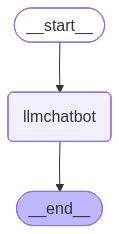

In [8]:
from IPython.display import display,Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error displaying graph:", e)

In [9]:
response=graph.invoke({"messages":"hi"})
response['messages'][-1].content
for event in graph.stream({"messages":"hi"}):
    # print(event['messages'][-1].content)
    for value in event.values():
        print(value["messages"][-1].content)

It's nice to meet you. Is there something I can help you with or would you like to chat?


# Building with External Tools
# Tavily Tool


In [10]:
from langchain_tavily import TavilySearch
tool=TavilySearch(max_result=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeli

In [11]:
llm_with_tools=llm.bind_tools(tool)
llm_with_tools

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\adity\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\adity\AppData\Local\Temp\ipykernel_5024\3504288490.py", line 1, in <module>
    llm_with_tools=llm.bind_tools(tool)
  File "c:\Users\adity\miniconda3\Lib\site-packages\langchain_groq\chat_models.py", line 874, in bind_tools
    formatted_tools = [convert_to_openai_tool(tool) for tool in tools]
                       ~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\adity\miniconda3\Lib\site-packages\langchain_core\utils\function_calling.py", line 556, in convert_to_openai_tool
    oai_function = convert_to_openai_function(tool, strict=strict)
  File "c:\Users\adity\miniconda3\Lib\site-packages\langchain_core\utils\function_calling.py", line 453, in convert_to_openai_function
    raise ValueError(msg)
ValueError: Unsupported 

In [12]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}
# defination
builder=StateGraph(State)
builder.add_node("tools_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tool))
# add edges
builder.add_edge(START,"tools_calling_llm")
# conditional edges
builder.add_conditional_edges(
    "tools_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)
# compile the graph
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\adity\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\adity\AppData\Local\Temp\ipykernel_5024\4282916606.py", line 9, in <module>
    builder.add_node("tools",ToolNode(tool))
                             ~~~~~~~~^^^^^^
  File "c:\Users\adity\miniconda3\Lib\site-packages\langgraph\prebuilt\tool_node.py", line 775, in __init__
    tool_ = create_tool(cast("type[BaseTool]", tool))
  File "c:\Users\adity\miniconda3\Lib\site-packages\langchain_core\tools\convert.py", line 378, in tool
    raise ValueError(msg)
ValueError: The first argument must be a string or a callable with a __name__ for tool decorator. Got <class 'tuple'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\adity\miniconda3\Lib\site-package

In [ ]:
response=graph.invoke({"messages":"what is the  recenct blockchain news"})

In [ ]:
response['messages'][-1].content
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the  recenct blockchain news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (0ab2kctnc)
 Call ID: 0ab2kctnc
  Args:
    query: recent blockchain news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent blockchain news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.bitget.com/amp/news/detail/12560605187705", "title": "DMG Blockchain discloses increase in bitcoin holdings to 414 and receives $1.5 million energy efficiency award - Bitget", "score": 0.6862234, "published_date": "Sat, 07 Feb 2026 14:56:07 GMT", "content": "Bitget App\n\nTrade smarter\n\nHomepageSign up\n\nBitget>\n\nNews>\n\nDMG Blockchain discloses increase in bitcoin holdings to 414 and receives $1.5 million energy ef

In [ ]:
response=graph.invoke({"messages":"what is the latest tech news"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest tech news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (12kd8z1x3)
 Call ID: 12kd8z1x3
  Args:
    query: latest tech news
    search_depth: basic
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest tech news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://pitchbook.com/news/articles/software-exposure-material-in-clos-but-ai-risk-not-uniform-says-moodys", "title": "Software exposure material in CLOs but AI risk not uniform, says Moody’s - pitchbook.com", "score": 0.52612424, "published_date": "Tue, 10 Feb 2026 15:24:01 GMT", "content": "*   Image 35: 2025-desktop-solution-outlined-white-icon.svg Request a Free Trial Request your free trial to access PitchBook and act confidently. *   Image 36: 2025-s

# REACT AGENT  ARCHTITECUTRE

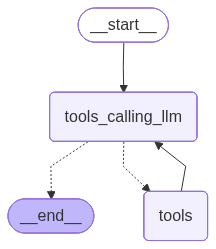

In [ ]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}
# defination
builder=StateGraph(State)
builder.add_node("tools_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tool))
# add edges
builder.add_edge(START,"tools_calling_llm")
# conditional edges
builder.add_conditional_edges(
    "tools_calling_llm",
    tools_condition
)
builder.add_edge("tools","tools_calling_llm")
# compile the graph
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
response=graph.invoke({"messages":"what is the latest tech news"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest tech news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4tjxsg038)
 Call ID: 4tjxsg038
  Args:
    query: latest tech news
    search_depth: basic
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest tech news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://pitchbook.com/news/articles/software-exposure-material-in-clos-but-ai-risk-not-uniform-says-moodys", "title": "Software exposure material in CLOs but AI risk not uniform, says Moody’s - pitchbook.com", "score": 0.52597815, "published_date": "Tue, 10 Feb 2026 15:24:01 GMT", "content": "*   Image 35: 2025-desktop-solution-outlined-white-icon.svg Request a Free Trial Request your free trial to access PitchBook and act confidently. *   Image 36: 2025-s

ADDING MEMORY IN AGENTIC AI

In [46]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}
# defination
builder=StateGraph(State)
builder.add_node("tools_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tool))
# add edges
builder.add_edge(START,"tools_calling_llm")
# conditional edges
builder.add_conditional_edges(
    "tools_calling_llm",
    tools_condition
)
builder.add_edge("tools","tools_calling_llm")
# compile the graph
graph=builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\adity\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\adity\AppData\Local\Temp\ipykernel_12960\2656882627.py", line 11, in <module>
    builder.add_node("tools",ToolNode(tool))
                             ~~~~~~~~^^^^^^
  File "c:\Users\adity\miniconda3\Lib\site-packages\langgraph\prebuilt\tool_node.py", line 775, in __init__
    tool_ = create_tool(cast("type[BaseTool]", tool))
  File "c:\Users\adity\miniconda3\Lib\site-packages\langchain_core\tools\convert.py", line 378, in tool
    raise ValueError(msg)
ValueError: The first argument must be a string or a callable with a __name__ for tool decorator. Got <class 'tuple'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\adity\miniconda3\Lib\site-packa

In [43]:
config={"configurable":{"thread":"1"}}
response=graph.invoke({"messages":"Hi my name is Elliot"},config=config)
response

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\adity\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\adity\AppData\Local\Temp\ipykernel_12960\3277385961.py", line 2, in <module>
    response=graph.invoke({"messages":"Hi my name is Elliot"},config=config)
             ^^^^^^^^^^^^
AttributeError: 'StateGraph' object has no attribute 'invoke'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\adity\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2176, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "c:\Users\adity\miniconda3\Lib\site-packages\IPython\core\ultratb.py", line 1182, in structured_traceback
    return FormattedTB.structured_traceback(
       

In [ ]:
response['messages'][-1].content

"Hello Elliot! It's nice to meet you. Is there something I can help you with or would you like to chat?"

STREAMING

In [19]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [28]:
def superbot(state:State):
    return({"messages":[llm.invoke(state['messages'])]})

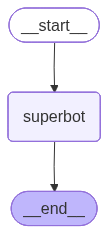

In [40]:
graph=StateGraph(State)
graph.add_node("superbot",superbot)
graph.add_edge(START,"superbot")
graph.add_edge("superbot",END)
graph_builder=graph.compile(checkpointer=memory)
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [41]:
config={"configurable":{"thread_id":"1"}}
graph_builder.invoke({"messages":"Hi There"},config)

{'messages': [HumanMessage(content='Hi There', additional_kwargs={}, response_metadata={}, id='c9202dae-44c4-49f1-b0dc-af44546a8374'),
  AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 37, 'total_tokens': 60, 'completion_time': 0.053002508, 'completion_tokens_details': None, 'prompt_time': 0.002207959, 'prompt_tokens_details': None, 'queue_time': 0.047864391, 'total_time': 0.055210467}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c5772-c47a-7c41-a5fc-cb5a878d4b94-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 37, 'output_tokens': 23, 'total_tokens': 60})]}

In [42]:
config={"configurable":{"thread_id":"1"}}
for c in graph_builder.invoke({"messages":"Hi There"},config,stream_mode='updates'):
    print(c)
    

{'superbot': {'messages': [AIMessage(content="Hello again. It seems like we're starting fresh. How's your day going so far? Is there something on your mind that you'd like to talk about, or are you just looking for some conversation? I'm here to listen and help if I can.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 71, 'total_tokens': 125, 'completion_time': 0.126115786, 'completion_tokens_details': None, 'prompt_time': 0.007387277, 'prompt_tokens_details': None, 'queue_time': 0.048696313, 'total_time': 0.133503063}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c5772-db0f-7343-9cc4-482246dc223c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 71, 'output_tokens': 54, 'total_tokens': 125})]}}
